In [112]:
# Imports
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, ShuffleSplit
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import r2_score, f1_score, precision_score, recall_score, roc_auc_score
from collections import defaultdict

# My scripts 
import nltk_helper as nh

%matplotlib inline

plt.style.use('seaborn')

In [141]:
# get data 
df = pd.read_pickle('../data/data.pkl')

In [142]:
drop_col = ['tags', 'date_last_updated','rating', 'rating_gte_4', 'warning']
text_col = ['summary', 'ch1', 'ch2', 'ch3', 'ch4', 'ch5']

In [143]:
# Get columns 
X = df.drop(drop_col, axis = 1)
y = df[['rating_gte_4', 'rating']]

In [144]:
# Do train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)  

In [145]:
# Get titles 
X_train_titles = X_train.title
X_test_titles = X_test.title

'''
X_train.drop('title', axis=1, inplace=True)
X_test.drop('title', axis=1, inplace=True)
'''

"\nX_train.drop('title', axis=1, inplace=True)\nX_test.drop('title', axis=1, inplace=True)\n"

In [146]:
print(f'Train Shape: {X_train.shape}   Test Shape: {X_test.shape}')

Train Shape: (2053, 95)   Test Shape: (514, 95)


---
---
**Make text columns into NMFs**

In [10]:
# Make text vectors
tfid = dict()
for col in text_col:
    tfid[col] = TfidfVectorizer(tokenizer = nh.prep_text)
    
    # Fit tfid
    tfid[col].fit(X_train[col])

/home/noel/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [35]:
# Fit NMF 
def fit_nmf(data, tfid, n = 10, max_i = 500):
    # Transform data 
    X = tfid.transform(data)
    
    nmf = NMF(n_components = n, max_iter = max_i)
    nmf.fit(X)
    
    W = nmf.transform(X)
    H = nmf.components_
    
    df_H = pd.DataFrame(H, columns = tfid.get_feature_names())
    
    # Get Topic name 
    column_names = [f'{data.name}_topic_{i}' for i in range(n)]

    df_W = pd.DataFrame(W, index = data.index, columns = column_names)
    
    # Reset index 
    df_W
    df_H
    
    return nmf, df_W, df_H

In [147]:
# Get H and W's
Hs = []
Ws = []

## Set up text to nmf
for col in text_col:
    # NMF or train data 
    _, W, H = fit_nmf(X_train[col], tfid[col])
    X_train = X_train.merge(W, left_index=True, right_index=True )
    
    Hs.append(H)
    Ws.append(W)
    
    # NMF or test data 
    _, W, H = fit_nmf(X_test[col], tfid[col])
    X_test = X_test.merge(W, left_index=True, right_index=True)

/home/noel/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/home/noel/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [155]:
# Save csv files 
for i in range(len(text_col)):
    Hs[i].T.to_csv(f'../data/{text_col[i]}.csv')

---
---
**Make Training and Test Dataset**

In [42]:
drop_txt = ['summary', 'ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'title']

In [43]:
X_train.drop(drop_txt, axis = 1, inplace=True)
X_test.drop(drop_txt, axis = 1, inplace=True)

---
---
**Make Random Forest Model**

In [48]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 80, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 17, 24, 31, 38, 45, 52, 59, 66, 73, 80, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [49]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfr = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfr_random = RandomizedSearchCV(estimator = rfr, param_distributions = random_grid, 
                                n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rfr_random.fit(X_train, y_train['rating'])

# Return best param
best_params = rfr_random.best_params_
best_params

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.7min finished


{'n_estimators': 911,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [54]:
# CV 
rfr = RandomForestRegressor(random_state=0, **best_params)
scores = defaultdict(list)

# CV with shuffle splits 
splitter = ShuffleSplit(5, test_size  = 0.2)
names = X_train.columns

# Do some CV 
for train_index, test_index in splitter.split(X_train, y_train['rating']):
    X_traincv, X_testcv = X_train.values[train_index], X_train.values[test_index]
    y_traincv, y_testcv = y_train['rating'].values[train_index], y_train['rating'].values[test_index]
    
    # Fit model 
    rfr.fit(X_traincv, y_traincv)
    
    # Make get accuracy 
    acc = r2_score(y_testcv, rfr.predict(X_testcv))
    
    # Make some prediction 
    for i in range(X_train.shape[1]):
        X_t = X_testcv.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = r2_score(y_testcv, rfr.predict(X_t))
        scores[names[i]].append((acc-shuff_acc)/acc)

score_series = pd.DataFrame(scores).mean()
scores = pd.DataFrame({'Mean Decrease Accuracy' : score_series})

<AxesSubplot:>

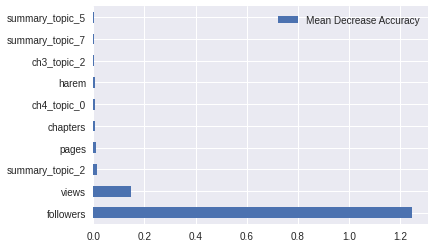

In [58]:
scores.sort_values(by='Mean Decreas# CV 
rfr = RandomForestRegressor(random_state=0, **best_params)
scores = defaultdict(list)

# CV with shuffle splits 
splitter = ShuffleSplit(5, test_size  = 0.2)
names = X_train.columns

# Do some CV 
for train_index, test_index in splitter.split(X_train, y_train['rating']):
    X_traincv, X_testcv = X_train.values[train_index], X_train.values[test_index]
    y_traincv, y_testcv = y_train['rating'].values[train_index], y_train['rating'].values[test_index]
    
    # Fit model 
    rfr.fit(X_traincv, y_traincv)
    
    # Make get accuracy 
    acc = r2_score(y_testcv, rfr.predict(X_testcv))
    
    # Make some prediction 
    for i in range(X_train.shape[1]):
        X_t = X_testcv.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = r2_score(y_testcv, rfr.predict(X_t))
        scores[names[i]].append((acc-shuff_acc)/acc)

score_series = pd.DataFrame(scores).mean()
scores = pd.DataFrame({'Mean Decrease Accuracy' : score_series})e Accuracy', ascending = False)[0:10].plot(kind='barh', figsize=(6,4))

In [56]:
r2_score(y_test['rating'], rfr.predict(X_test))

0.5138046827566733

In [59]:
scores.sort_values(by='Mean Decrease Accuracy', ascending = False)[0:10].index

Index(['followers', 'views', 'summary_topic_2', 'pages', 'chapters',
       'ch4_topic_0', 'harem', 'ch3_topic_2', 'summary_topic_7',
       'summary_topic_5'],
      dtype='object')

---
---
**Random Forest Classifier**

In [61]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfc = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, 
                                n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rfc_random.fit(X_train, y_train['rating_gte_4'])

# Return best param
best_params = rfc_random.best_params_
best_params

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.1min finished


{'n_estimators': 377,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': False}

In [128]:
X_train.columns

Index(['pages', 'chapters', 'adventure', 'comedy', 'fantasy', 'romance',
       'male', 'martial', 'arts', 'portal',
       ...
       'ch5_topic_0', 'ch5_topic_1', 'ch5_topic_2', 'ch5_topic_3',
       'ch5_topic_4', 'ch5_topic_5', 'ch5_topic_6', 'ch5_topic_7',
       'ch5_topic_8', 'ch5_topic_9'],
      dtype='object', length=146)

In [129]:
# Remove some variables from the data 
X_train.drop(['chapters', 'pages', 'followers', 'views'], axis = 1, inplace = True)

In [130]:
# CV 
rfc = RandomForestClassifier(random_state=0, **best_params)
scores = defaultdict(list)
f1 = dict()
threshold = [0.3, 0.4, 0.43,  0.44, 0.45, 0.47, 0.5, 0.6, 0.7]

# CV with shuffle splits 
splitter = ShuffleSplit(5, test_size  = 0.2)
names = X_train.columns


# Do some CV 
for train_index, test_index in splitter.split(X_train, y_train['rating_gte_4']):
    X_traincv, X_testcv = X_train.values[train_index], X_train.values[test_index]
    y_traincv, y_testcv = y_train['rating_gte_4'].values[train_index], y_train['rating_gte_4'].values[test_index]
    
    # Fit model 
    rfc.fit(X_traincv, y_traincv)
    
    # Make some prediction 
    pred = rfc.predict(X_testcv)
    
    scores['F1'].append(f1_score(y_testcv, pred))
    scores['Precision'].append(precision_score(y_testcv, pred))
    scores['Recall'].append(recall_score(y_testcv, pred))
    scores['ROC AUC'].append(roc_auc_score(y_testcv, pred))

score_series = pd.DataFrame(scores).mean()
all_scores = pd.DataFrame(scores)
scores = pd.DataFrame({'Scores Mean' : score_series})

In [131]:
scores

,Scores Mean
F1,0.762682
Precision,0.678804
Recall,0.870967
ROC AUC,0.682395


In [ ]:
	Scores Mean no follow, view
F1	0.780658
Precision	0.716196
Recall	0.858355
ROC AUC	0.691551

	Scores Mean no ^ and pages, chapters 
F1	0.762682
Precision	0.678804
Recall	0.870967
ROC AUC	0.682395

In [126]:
all_scores

,F1,Precision,Recall,ROC AUC
0,0.777344,0.695804,0.880531,0.705130
1,0.794727,0.722603,0.882845,0.705957
2,0.794872,0.738095,0.861111,0.688417
3,0.769811,0.713287,0.836066,0.672524
4,0.766537,0.711191,0.831224,0.685727


In [137]:
# CV 
rfc = RandomForestClassifier(random_state=0, **best_params)
rfc.fit(X_train, y_train['rating_gte_4'])

RandomForestClassifier(bootstrap=False, max_depth=80, max_features='sqrt',
                       min_samples_leaf=2, n_estimators=377, random_state=0)

In [140]:
f1_score(y_test['rating_gte_4'], rfc.predict(X_test[list(X_train.columns)]))

0.7371695178849144

In [134]:
features = pd.DataFrame( {'importance': rfc.feature_importances_}, index = X_train.columns)

In [136]:
features.sort_values(by = 'importance', ascending = False)[0:10]

,importance
ch2_topic_2,0.029842
ch3_topic_2,0.029010
ch4_topic_3,0.025720
ch4_topic_2,0.023247
ch5_topic_2,0.022814
summary_topic_8,0.021481
summary_topic_0,0.021363
ch5_topic_3,0.020809
summary_topic_3,0.020522
ch1_topic_4,0.020105
